<a href="https://colab.research.google.com/github/vanditaagarwal/Generation_of_Images_from_Noise_using_DCGAN/blob/main/DL_Assignment5_Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries

import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision import models
import cv2

In [ ]:
# Making directory to store images and resultant images

os.makedirs("images", exist_ok=True)

In [ ]:
# Transferring to cuda
cuda = True if torch.cuda.is_available() else False

In [ ]:
# Defining Hyperparameters

n_epochs = 10
batch_size = 1024
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 3
sample_interval = 400


In [ ]:
# Downloading emnist dataset with balanced split and loading dataloader
os.makedirs("../../data/emnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.EMNIST(
        "../../data/emnist",
        split='balanced',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
# Defining function to initialize weughts for batch norm and convolution layers
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Defining Generator for DCGANS
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        #img = cv2.resize(img,(32,32))
        return img


In [ ]:
# Calling and printing generator
gen = Generator()
print(gen)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
)


In [ ]:
# Defining VGG11 discriminator for DCGAN as my roll no. is M20MA208 and roll no. % 2 == 0:
class DiscriminatorVGG11(nn.Module):
    def __init__(self):
        super(DiscriminatorVGG11, self).__init__()

        self.vgg11 = models.vgg11(pretrained=True)
        for param in self.vgg11.parameters():
            param.requires_grad = False
        self.vgg11.classifier[-1] = nn.Linear(4096, 1)

    def forward(self, img):
        validity = self.vgg11(img)
        validity = torch.sigmoid(validity)
        return validity


In [ ]:
# Calling and printing VGG11 discrimnator
dis = DiscriminatorVGG11()
print(dis)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DiscriminatorVGG11(
  (vgg11): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(k

In [ ]:
# Defining Loss function and optimizers for generator and discriminator
adver_loss = torch.nn.BCELoss()

# Optimizers
optimizer_G = torch.optim.Adam(gen.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(dis.parameters(), lr=lr, betas=(b1, b2))

In [ ]:
from logging import disable
# Checking and alloting cuda
if cuda:
    gen.cuda()
    dis.cuda()
    adver_loss.cuda()

In [ ]:
# Initializing weights
gen.apply(weights_init_normal)
dis.apply(weights_init_normal)


DiscriminatorVGG11(
  (vgg11): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(k

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
# ----------
#  Training
# ----------

img_list = []
G_losses = []
D_losses = []
iters = 0


fixed_noise = torch.randn(64, latent_dim, 1, 1)


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        print("imgs", imgs.shape)
        # Configure input
        re_imgs = Variable(imgs.type(Tensor))
        print("real imgs", re_imgs.shape)
        re_imgs = re_imgs.repeat(1, 3, 1, 1)
        print("real imgs", re_imgs.shape)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        print("z",z.shape)
        # Generate a batch of images
        gen_imgs = gen(z)
        print(gen_imgs.shape)


        # Loss measures generator's ability to fool the discriminator
        g_loss = adver_loss(dis(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        re_loss = adver_loss(dis(re_imgs), valid)
        fa_loss = adver_loss(dis(gen_imgs.detach()), fake)
        d_loss = (re_loss + fa_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # lists to store losses for generators and discriminators
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # ten random noise vectors uniformly generated that act as latent representation vectors
        z1 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z2 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z3 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z4 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z5 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z6 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z7 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z8 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z9 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
        z10 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))

        #z = [z1, z2, z3, z4, z5, z6, z7, z8, z9, z10]


        # Generate images after first epoch
        if epoch == 0:
          with torch.no_grad():
            z1 = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))
            #print("z1",z1.shape)

            gen_imgs1 = gen(z1)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 1, nrow=5, normalize=True)
            gen_imgs1 = gen(z2)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 2, nrow=5, normalize=True)
            gen_imgs1 = gen(z3)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 3, nrow=5, normalize=True)
            gen_imgs1 = gen(z4)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 4, nrow=5, normalize=True)
            gen_imgs1 = gen(z5)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 5, nrow=5, normalize=True)
            gen_imgs1 = gen(z6)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 6, nrow=5, normalize=True)
            gen_imgs1 = gen(z7)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 7, nrow=5, normalize=True)
            gen_imgs1 = gen(z8)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 8, nrow=5, normalize=True)
            gen_imgs1 = gen(z9)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 9, nrow=5, normalize=True)
            gen_imgs1 = gen(z10)
            save_image(gen_imgs1.data[:25], "images/epoch_0_%d.png" % 10, nrow=5, normalize=True)



        # Generate images after n/2 th epoch
        if epoch == n_epochs // 2:
          with torch.no_grad():
            gen_imgs1 = gen(z1)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 1, nrow=5, normalize=True)
            gen_imgs1 = gen(z2)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 2, nrow=5, normalize=True)
            gen_imgs1 = gen(z3)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 3, nrow=5, normalize=True)
            gen_imgs1 = gen(z4)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 4, nrow=5, normalize=True)
            gen_imgs1 = gen(z5)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 5, nrow=5, normalize=True)
            gen_imgs1 = gen(z6)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 6, nrow=5, normalize=True)
            gen_imgs1 = gen(z7)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 7, nrow=5, normalize=True)
            gen_imgs1 = gen(z8)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 8, nrow=5, normalize=True)
            gen_imgs1 = gen(z9)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 9, nrow=5, normalize=True)
            gen_imgs1 = gen(z10)
            save_image(gen_imgs1.data[:25], "images/epoch_half_%d.png" % 10, nrow=5, normalize=True)

        # Generate images after last epoch
        if epoch == n_epochs-1:
          with torch.no_grad():
            gen_imgs1 = gen(z1)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 1, nrow=5, normalize=True)
            gen_imgs1 = gen(z2)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 2, nrow=5, normalize=True)
            gen_imgs1 = gen(z3)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 3, nrow=5, normalize=True)
            gen_imgs1 = gen(z4)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 4, nrow=5, normalize=True)
            gen_imgs1 = gen(z5)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 5, nrow=5, normalize=True)
            gen_imgs1 = gen(z6)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 6, nrow=5, normalize=True)
            gen_imgs1 = gen(z7)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 7, nrow=5, normalize=True)
            gen_imgs1 = gen(z8)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 8, nrow=5, normalize=True)
            gen_imgs1 = gen(z9)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 9, nrow=5, normalize=True)
            gen_imgs1 = gen(z10)
            save_image(gen_imgs1.data[:25], "images/epoch_n_%d.png" % 10, nrow=5, normalize=True)



        print(
            "[Epoch %d/%d] [Mini-Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


Streaming output truncated to the last 5000 lines.
torch.Size([1024, 3, 32, 32])
[Epoch 2/10] [Mini-Batch 54/111] [D loss: 0.697982] [G loss: 0.708044]
imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 3, 32, 32])
z torch.Size([1024, 100])
torch.Size([1024, 3, 32, 32])
[Epoch 2/10] [Mini-Batch 55/111] [D loss: 0.692597] [G loss: 0.698853]
imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 3, 32, 32])
z torch.Size([1024, 100])
torch.Size([1024, 3, 32, 32])
[Epoch 2/10] [Mini-Batch 56/111] [D loss: 0.694020] [G loss: 0.698957]
imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 3, 32, 32])
z torch.Size([1024, 100])
torch.Size([1024, 3, 32, 32])
[Epoch 2/10] [Mini-Batch 57/111] [D loss: 0.695020] [G loss: 0.697043]
imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 1, 32, 32])
real imgs torch.Size([1024, 3, 32, 32])
z torch

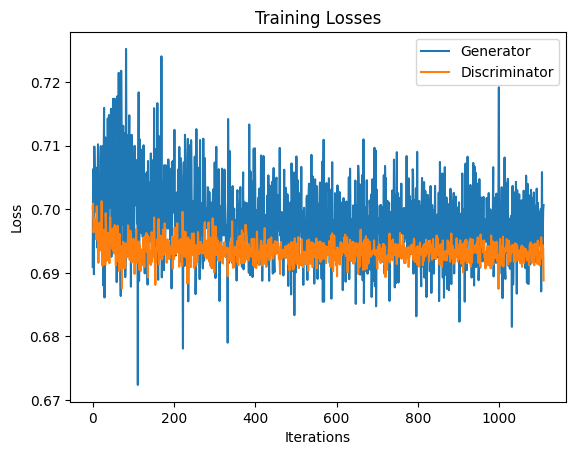

In [ ]:
import matplotlib.pyplot as plt

# plot the losses
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

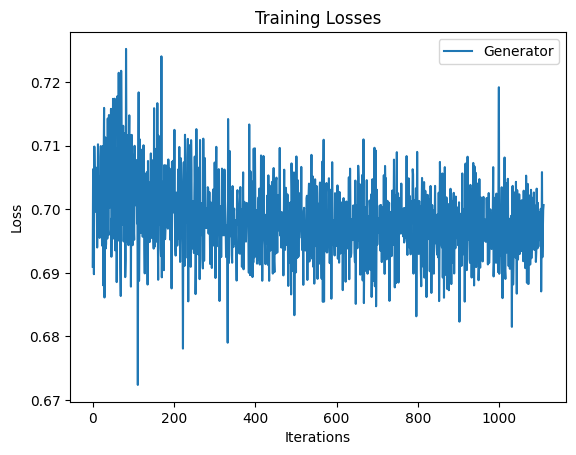

In [ ]:
# plot the losses
plt.plot(G_losses, label='Generator')
#plt.plot(D_losses, label='Discriminator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

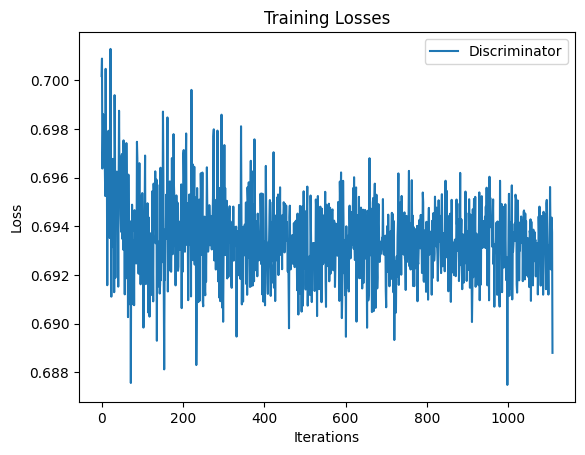

In [ ]:
# plot the losses
#plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

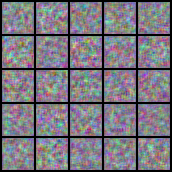

In [ ]:
from IPython.display import Image
Image(filename="images/0.png")


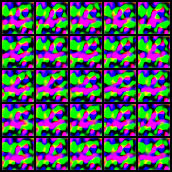

In [ ]:
Image(filename="/content/images/epoch_0_4.png")

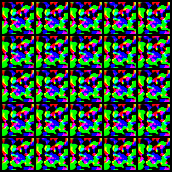

In [ ]:
Image(filename="/content/images/epoch_half_4.png")

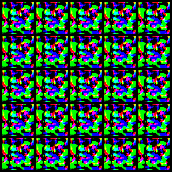

In [ ]:
Image(filename="/content/images/epoch_n_5.png")

Best generated image by MOdel


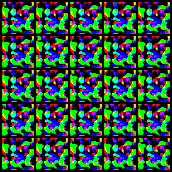

In [ ]:
print("Best generated image by MOdel")
Image(filename="/content/images/800.png")